# Clustering Neighborhoods in Toronto using Foursquare API

In this Project, we will explore, segment, and cluster the neighborhoods in the city of Toronto.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format. Once the data is in a structured format, we start to explore and cluster the neighborhoods in the city of Toronto.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-left: 20px">
    
####   [1. Download and Explore Dataset](#1-bullet)

####   [2. Explore Neighborhoods in Toronto](#2-bullet)

####   [3. Analyze Each Neighborhood](#3-bullet)

####   [4. Cluster Neighborhoods](#4-bullet)

####   [5. Examine Clusters](#5-bullet)

####   [6. Conclusion](#6-bullet)

Before we get the data and start exploring it, let's import the libraries that we will need.

In [323]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)

import json # library to handle JSON files
import requests # library to handle requests

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline

import folium

## 1. Download and Explore Dataset <a class="anchor" id="1-bullet"></a>

We build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

In [324]:
# we use pandas to read the table into a pandas dataframe.

toronto= pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [325]:
toronto.shape

(287, 3)

We only process the cells that have an assigned borough and ignore cells with a borough that is **Not assigned**:

In [326]:
toronto= toronto[toronto['Borough']!='Not assigned'].reset_index(drop=True)
toronto.head(6)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Queen's Park,Not assigned


In [327]:
toronto.shape

(210, 3)

**Note:** If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

In [328]:
toronto[toronto['Neighbourhood']=='Not assigned']

,Postcode,Borough,Neighbourhood
5,M7A,Queen's Park,Not assigned


There's only one **Not assigned** Neighbourhood:

In [329]:
toronto.loc[5,'Neighbourhood']="Queen's Park"

In [330]:
toronto.head(6)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Queen's Park,Queen's Park


**Note:** More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [331]:
print('Unique Postcodes:      ', toronto['Postcode'].nunique())
print('Unique Boroughs:       ', toronto['Borough'].nunique())
print('Unique Neighbourhoods: ', toronto['Neighbourhood'].nunique())

Unique Postcodes:       103
Unique Boroughs:        11
Unique Neighbourhoods:  207


In [332]:
toronto = toronto.groupby(['Postcode', 'Borough'], sort = False).agg( ', '.join).reset_index()
toronto.head(5)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


#### Number of rows of the dataframe:

In [333]:
print("Shape of toronto dataframe: ",toronto.shape)

Shape of toronto dataframe:  (103, 3)


In [334]:
print("Number of rows of toronto dataframe: ",toronto.shape[0])

Number of rows of toronto dataframe:  103


#### Get the latitude and longitude values of neighbourhoods

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

**First Try:** 

In [335]:
# using Nominatim func to convert an address into latitude and longitude values

from geopy.geocoders import Nominatim

def get_coor(postcode):
    """
    Input: post code of Toronto
    Return: a tuple of (lat,long)
    """
    address = f'{postcode}, Toronto, Ontario'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    return location.latitude, location.longitude

def get_lat(postcode):
    """
    Input: post code of Toronto
    Return: latitude
    """
    address = f'{postcode}, Toronto, Ontario'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    try:
        return location.latitude
    except:
        return np.nan

    
def get_long(postcode):
    """
    Input: post code of Toronto
    Return: longitude
    """
    address = f'{postcode}, Toronto, Ontario'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    return location.longitude
    
    
# toronto['latitude']= toronto['Postcode'].apply(get_lat)
# toronto['longitude']= toronto['Postcode'].apply(get_long)

# This methode gets sevice errors. We use another one.

**Second Try:** 

In [336]:
import geocoder 

### initialize your variable to None
# lat_lng_coords = None

### sample postal code
# postal_code= 'M3A'

### loop until you get the coordinates

# while(lat_lng_coords is None):
#     g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#     lat_lng_coords = g.latlng

# latitude = lat_lng_coords[0]
# longitude = lat_lng_coords[1]

# print(latitude,longitude)

### This doesn't work either.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. 

**Third Try:** 

In [337]:
# Using a csv file with all the geographical data of toronto

!wget -q -O 'Toronto_location.csv' http://cocl.us/Geospatial_data
to_loc = pd.read_csv('Toronto_location.csv')
to_loc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [338]:
to_loc.rename(columns={'Postal Code':'Postcode'},inplace=True)

In [339]:
# Merging the two dataframes
toronto= toronto.merge(to_loc,on='Postcode')

In [340]:
toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


#### Create a map of Toronto with neighborhoods superimposed on top

In [341]:
# get the lat and lon of Toronto

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode('Toronto, Ontario')
latitude= location.latitude
longitude= location.longitude


In [342]:
# create map of Toronto using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], 
                                           toronto['Longitude'], 
                                           toronto['Borough'], 
                                           toronto['Neighbourhood']):
    
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  
    
map_to

Our dataframe is ready now. We can start to explore and cluster the neighborhoods.

## 2. Explore Neighborhoods in Toronto <a class="anchor" id="2-bullet"></a>

#### For starters, let's get the top 100 venues that are in "M5B" within a radius of 500 meters.

We use Foursquare Api to create the GET request URL.

In [343]:
# Foursquare credential are already saved in a JSON file

with open('foursquare_credentials.json') as f:
    foursquare= json.load(f)

In [344]:
CLIENT_ID= foursquare['CLIENT_ID']
CLIENT_SECRET= foursquare['CLIENT_SECRET']

neighborhood_latitude= toronto.loc[9, 'Latitude']
neighborhood_longitude= toronto.loc[9, 'Longitude']

url= 'https://api.foursquare.com/v2/venues/explore'

params = dict(client_id=CLIENT_ID,
              client_secret=CLIENT_SECRET,
              v='20180605',
              ll=f'{neighborhood_latitude},{neighborhood_longitude}',
              radius=500,
              limit=100)

In [345]:
results_M5B = requests.get(url=url, params=params).json()
print(json.dumps(results_M5B, indent=3))

{
   "meta": {
      "code": 200,
      "requestId": "5df271e129ce6a001b06e60e"
   },
   "response": {
      "suggestedFilters": {
         "header": "Tap to show:",
         "filters": [
            {
               "name": "Open now",
               "key": "openNow"
            }
         ]
      },
      "headerLocation": "Downtown Toronto",
      "headerFullLocation": "Downtown Toronto, Toronto",
      "headerLocationGranularity": "neighborhood",
      "totalResults": 131,
      "suggestedBounds": {
         "ne": {
            "lat": 43.6616618045,
            "lng": -79.37272880013877
         },
         "sw": {
            "lat": 43.652661795499995,
            "lng": -79.3851453998612
         }
      },
      "groups": [
         {
            "type": "Recommended Places",
            "name": "recommended",
            "items": [
               {
                  "reasons": {
                     "count": 0,
                     "items": [
                        {
         

Let's check if there are 100 items found:

In [346]:
len(results_M5B['response']['groups'][0]['items'])

100

Print 10 first venues and their category name:

In [347]:
venues_M5B= results_M5B['response']['groups'][0]['items']

for item in (venues_M5B[:10]):
    print(item['venue']['categories'][0]['name'],
          ':',
          (20-len(item['venue']['categories'][0]['name']))*' ', 
          item['venue']['name'])

Clothing Store :        UNIQLO ユニクロ
Comic Shop :            Silver Snail Comics
Pizza Place :           Blaze Pizza
Plaza :                 Yonge-Dundas Square
Café :                  Page One Cafe
Tea Room :              DAVIDsTEA
Burrito Place :         Burrito Boyz
Ramen Restaurant :      Hokkaido Ramen Santouka らーめん山頭火
Theater :               Ed Mirvish Theatre
Music Venue :           Jazz Bistro


#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [348]:
df_M5B= json_normalize(venues_M5B)
df_M5B['Postcode'] = 'M5B'
df_M5B.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.events.count,venue.events.summary,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id,Postcode
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-57eda381498ebe0e6ef40972-0,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",NaN,NaN,57eda381498ebe0e6ef40972,220 Yonge St,CA,Toronto,Canada,at Dundas St W,195,"[220 Yonge St (at Dundas St W), Toronto ON M5B...","[{'label': 'display', 'lat': 43.65591027779457...",43.655910,-79.380641,Downtown Toronto,M5B 2H1,ON,UNIQLO ユニクロ,0,[],NaN,M5B
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c062f964a5200bf820e3-1,"[{'id': '52f2ab2ebcbc57f1066b8b18', 'name': 'C...",NaN,NaN,4ad4c062f964a5200bf820e3,329 Yonge St,CA,Toronto,Canada,at Dundas St E,199,"[329 Yonge St (at Dundas St E), Toronto ON M5B...","[{'label': 'display', 'lat': 43.65703137958407...",43.657031,-79.381403,NaN,M5B 1R7,ON,Silver Snail Comics,0,[],NaN,M5B
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5615b6c4498e3c32c67ad78f-2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",NaN,NaN,5615b6c4498e3c32c67ad78f,"10 Dundas Street East, #124",CA,Toronto,Canada,NaN,112,"[10 Dundas Street East, #124, Toronto ON M5B 2...","[{'label': 'display', 'lat': 43.656518, 'lng':...",43.656518,-79.380015,NaN,M5B 2G9,ON,Blaze Pizza,0,[],NaN,M5B
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad8cd16f964a520c91421e3-3,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",NaN,NaN,4ad8cd16f964a520c91421e3,1 Dundas St E,CA,Toronto,Canada,at Yonge St,175,"[1 Dundas St E (at Yonge St), Toronto ON M5B 2...","[{'label': 'display', 'lat': 43.65605389742188...",43.656054,-79.380495,NaN,M5B 2R8,ON,Yonge-Dundas Square,0,[],68861986,M5B
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-56d4d1b3cd1035fe77e1492c-4,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",NaN,NaN,56d4d1b3cd1035fe77e1492c,106 Mutual St,CA,Toronto,Canada,btwn Dundas & Gould St,240,"[106 Mutual St (btwn Dundas & Gould St), Toron...","[{'label': 'display', 'lat': 43.65777161112601...",43.657772,-79.376073,NaN,M5B 2R7,ON,Page One Cafe,0,[],NaN,M5B


In [349]:
df_M5B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
reasons.count                      100 non-null int64
reasons.items                      100 non-null object
referralId                         100 non-null object
venue.categories                   100 non-null object
venue.events.count                 1 non-null float64
venue.events.summary               1 non-null object
venue.id                           100 non-null object
venue.location.address             99 non-null object
venue.location.cc                  100 non-null object
venue.location.city                100 non-null object
venue.location.country             100 non-null object
venue.location.crossStreet         76 non-null object
venue.location.distance            100 non-null int64
venue.location.formattedAddress    100 non-null object
venue.location.labeledLatLngs      99 non-null object
venue.location.lat                 100 non-null float64
venue.location.lng     

#### Add category name to the dataframe

In [350]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        try:
            categories_list = row['venue.categories']
        except:
            return None
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [351]:
# filter the category for each row
df_M5B['categories'] = df_M5B.apply(get_category_type, axis=1)

In [352]:
df_M5B.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.events.count,venue.events.summary,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id,Postcode,categories
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-57eda381498ebe0e6ef40972-0,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",NaN,NaN,57eda381498ebe0e6ef40972,220 Yonge St,CA,Toronto,Canada,at Dundas St W,195,"[220 Yonge St (at Dundas St W), Toronto ON M5B...","[{'label': 'display', 'lat': 43.65591027779457...",43.655910,-79.380641,Downtown Toronto,M5B 2H1,ON,UNIQLO ユニクロ,0,[],NaN,M5B,Clothing Store
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c062f964a5200bf820e3-1,"[{'id': '52f2ab2ebcbc57f1066b8b18', 'name': 'C...",NaN,NaN,4ad4c062f964a5200bf820e3,329 Yonge St,CA,Toronto,Canada,at Dundas St E,199,"[329 Yonge St (at Dundas St E), Toronto ON M5B...","[{'label': 'display', 'lat': 43.65703137958407...",43.657031,-79.381403,NaN,M5B 1R7,ON,Silver Snail Comics,0,[],NaN,M5B,Comic Shop
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5615b6c4498e3c32c67ad78f-2,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",NaN,NaN,5615b6c4498e3c32c67ad78f,"10 Dundas Street East, #124",CA,Toronto,Canada,NaN,112,"[10 Dundas Street East, #124, Toronto ON M5B 2...","[{'label': 'display', 'lat': 43.656518, 'lng':...",43.656518,-79.380015,NaN,M5B 2G9,ON,Blaze Pizza,0,[],NaN,M5B,Pizza Place
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad8cd16f964a520c91421e3-3,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",NaN,NaN,4ad8cd16f964a520c91421e3,1 Dundas St E,CA,Toronto,Canada,at Yonge St,175,"[1 Dundas St E (at Yonge St), Toronto ON M5B 2...","[{'label': 'display', 'lat': 43.65605389742188...",43.656054,-79.380495,NaN,M5B 2R8,ON,Yonge-Dundas Square,0,[],68861986,M5B,Plaza
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-56d4d1b3cd1035fe77e1492c-4,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",NaN,NaN,56d4d1b3cd1035fe77e1492c,106 Mutual St,CA,Toronto,Canada,btwn Dundas & Gould St,240,"[106 Mutual St (btwn Dundas & Gould St), Toron...","[{'label': 'display', 'lat': 43.65777161112601...",43.657772,-79.376073,NaN,M5B 2R7,ON,Page One Cafe,0,[],NaN,M5B,Café


Clean the dataframe and keep only the columns that we need:

In [353]:
columns_filtered= ['Postcode','venue.name','categories','venue.location.address','venue.location.city',
                   'venue.location.country','venue.location.distance',
                   'venue.location.lat','venue.location.lng','venue.id']

In [354]:
df_M5B_filtered= df_M5B[columns_filtered].copy()
df_M5B_filtered.head()

,Postcode,venue.name,categories,venue.location.address,venue.location.city,venue.location.country,venue.location.distance,venue.location.lat,venue.location.lng,venue.id
0,M5B,UNIQLO ユニクロ,Clothing Store,220 Yonge St,Toronto,Canada,195,43.655910,-79.380641,57eda381498ebe0e6ef40972
1,M5B,Silver Snail Comics,Comic Shop,329 Yonge St,Toronto,Canada,199,43.657031,-79.381403,4ad4c062f964a5200bf820e3
2,M5B,Blaze Pizza,Pizza Place,"10 Dundas Street East, #124",Toronto,Canada,112,43.656518,-79.380015,5615b6c4498e3c32c67ad78f
3,M5B,Yonge-Dundas Square,Plaza,1 Dundas St E,Toronto,Canada,175,43.656054,-79.380495,4ad8cd16f964a520c91421e3
4,M5B,Page One Cafe,Café,106 Mutual St,Toronto,Canada,240,43.657772,-79.376073,56d4d1b3cd1035fe77e1492c


In [355]:
df_M5B_filtered.rename(columns={'venue.location.lat':'venue_lat',
                                'venue.location.lng':'venue_lng',
                                'venue.id':'venue_id'}, inplace=True)

In [356]:
# clean column names by keeping only last term
df_M5B_filtered.columns = ([column.split('.')[-1] for column in df_M5B_filtered.columns[:-3]] + 
                           df_M5B_filtered.columns[-3:].values.tolist())

In [357]:
df_M5B_filtered.head()

,Postcode,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M5B,UNIQLO ユニクロ,Clothing Store,220 Yonge St,Toronto,Canada,195,43.655910,-79.380641,57eda381498ebe0e6ef40972
1,M5B,Silver Snail Comics,Comic Shop,329 Yonge St,Toronto,Canada,199,43.657031,-79.381403,4ad4c062f964a5200bf820e3
2,M5B,Blaze Pizza,Pizza Place,"10 Dundas Street East, #124",Toronto,Canada,112,43.656518,-79.380015,5615b6c4498e3c32c67ad78f
3,M5B,Yonge-Dundas Square,Plaza,1 Dundas St E,Toronto,Canada,175,43.656054,-79.380495,4ad8cd16f964a520c91421e3
4,M5B,Page One Cafe,Café,106 Mutual St,Toronto,Canada,240,43.657772,-79.376073,56d4d1b3cd1035fe77e1492c


### creat a function that repeats te same process for each Postcode in toronto dataframe

In [358]:
def get_nearby_venues(df, area_col_name, radius=500, endpoint='explore', log=False):
    
    """
    This Function takes a dataframe. It uses the lat and lng of areas 
    in that dataframe to search for nearby venues for each area.
    
    Parameters
    ----------
    df : DataFrame with at least three columns. One for areas and
        two for lat and lng namly "Latitude" and "Longitude"
    area_col_name : name of the column containg areas
    radius : Limit results to venues within this many meters 
        of the specified location, default 500
    endpoint: type of Endpoint. possible values: "explore", "search"
    log: if log is True, a log will be printed.
    
    Returns
    -------
    Dataframe : object, type of pandas.core.frame.DataFrame
        a Dataframe with the nearby venues
    
    """
    
    # Create an empty dataframe
    nearby_df= pd.DataFrame()
    
    # Foursquare API URL
    url= 'https://api.foursquare.com/v2/venues/'+ endpoint
    
    # Loop through each area
    for row in range(df.shape[0]):
        
        if log:
            print('==========',df.loc[row, area_col_name],'==========')

        # create the GET request url
        CLIENT_ID= foursquare['CLIENT_ID']
        CLIENT_SECRET= foursquare['CLIENT_SECRET']

        neighborhood_latitude= df.loc[row, 'Latitude']
        neighborhood_longitude= df.loc[row, 'Longitude']

        params = dict(client_id=CLIENT_ID,
                      client_secret=CLIENT_SECRET,
                      v='20180605',
                      ll=f'{neighborhood_latitude},{neighborhood_longitude}',
                      radius=500,
                      limit=100)
        
        if endpoint=='search':
            params['intent']='browse'

        if log:
            print('Sending request...')
            
        # request the JSON file with venue information
        res = requests.get(url=url, params=params).json()

        # collect useful information out of JSON file
        if endpoint=='search':
            vens= res['response']['venues']
        else:
            vens= res['response']['groups'][0]['items']
        
        if log:
            print('JSON into Dataframe...')
        
        # flatten JSON file and turn it into dataframe
        df_pc= json_normalize(vens)

        # Add Postcode to dataframe
        df_pc[area_col_name] = df.loc[row, area_col_name]

        if log:
            print('Getting Category Type...')
        
        # filter the category for each row
        df_pc['categories'] = df_pc.apply(get_category_type, axis=1)
        
        # Error handling in case JSON file is empty 
        try:
            
            if endpoint=='search':
                
                # keep useful rows
                columns_filtered= ['Postcode','name','categories','location.address','location.city',
                                   'location.country','location.distance','location.lat',
                                   'location.lng','id']
                
                df_pc_filtered= df_pc[columns_filtered].copy()

                if log:
                    print('Renaming columns...')
                
                # rename last three columns
                df_pc_filtered.rename(columns={'location.lat':'venue_lat',
                                                'location.lng':'venue_lng',
                                                'id':'venue_id'}, inplace=True)
            else:
                
                # keep useful rows
                columns_filtered= ['Postcode','venue.name','categories','venue.location.address',
                                   'venue.location.city','venue.location.country','venue.location.distance',
                                   'venue.location.lat','venue.location.lng','venue.id']
                
                df_pc_filtered= df_pc[columns_filtered].copy()
                
                if log:
                    print('Renaming columns...')
                
                # rename last three columns
                df_pc_filtered.rename(columns={'venue.location.lat':'venue_lat',
                                                'venue.location.lng':'venue_lng',
                                                'venue.id':'venue_id'}, inplace=True)
        except:
            print('JSON file empty!')
        

        # clean column names by keeping only last term
        df_pc_filtered.columns = ([column.split('.')[-1] for column in df_pc_filtered.columns[:-3]] + 
                                  df_pc_filtered.columns[-3:].values.tolist())
        
        # concatenate the dataframe to nearby_venues
        nearby_df= pd.concat([nearby_df,df_pc_filtered])
        
        if log:
            print(row,'...',toronto.loc[row, area_col_name], '... Done!\n\n')
            
    return nearby_df

Let's use the function:

In [359]:
vens_explore= get_nearby_venues(df=toronto, area_col_name='Postcode', log=True)

========== M3A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
0 ... M3A ... Done!


========== M4A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
1 ... M4A ... Done!


========== M5A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
2 ... M5A ... Done!


========== M6A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
3 ... M6A ... Done!


========== M7A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
4 ... M7A ... Done!


========== M9A ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
JSON file empty!
5 ... M9A ... Done!


========== M1B ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
6 ... M1B ... Done!


========== M3B ==========
Sending request...
JSON into Dat

JSON into Dataframe...
Getting Category Type...
Renaming columns...
61 ... M4N ... Done!


========== M5N ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
62 ... M5N ... Done!


========== M6N ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
63 ... M6N ... Done!


========== M9N ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
JSON file empty!
64 ... M9N ... Done!


========== M1P ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
65 ... M1P ... Done!


========== M2P ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
66 ... M2P ... Done!


========== M4P ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Renaming columns...
67 ... M4P ... Done!


========== M5P ==========
Sending request...
JSON into Dataframe...
Getting Category Type...
Ren

In [360]:
vens_explore.head()

,Postcode,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M3A,Brookbanks Park,Park,Toronto,Toronto,Canada,245,43.751976,-79.332140,4e8d9dcdd5fbbbb6b3003c7b
1,M3A,Variety Store,Food & Drink Shop,29 Valley Woods Road,Toronto,Canada,312,43.751974,-79.333114,4cb11e2075ebb60cd1c4caad
0,M4A,Victoria Village Arena,Hockey Arena,NaN,NaN,Canada,267,43.723481,-79.315635,4c633acb86b6be9a61268e34
1,M4A,Tim Hortons,Coffee Shop,1733 Eglinton Ave East,Toronto,Canada,202,43.725517,-79.313103,4bbe904a85fbb713420d7167
2,M4A,Portugril,Portuguese Restaurant,1733 Eglinton Avenue East,Toronto,Canada,224,43.725819,-79.312785,4f3ecce6e4b0587016b6f30d


In [361]:
vens_explore.shape

(2300, 10)

Let's see how many venues are found for each Postcode:

In [362]:
vens_explore.groupby('Postcode').count().sort_values('name').reset_index()

,Postcode,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M2L,1,1,1,1,1,1,1,1,1
1,M3K,2,2,2,2,2,2,2,2,2
2,M5N,2,2,1,2,2,2,2,2,2
3,M3A,2,2,2,2,2,2,2,2,2
4,M2M,2,2,1,2,2,2,2,2,2
5,M8X,2,2,1,1,2,2,2,2,2
6,M1M,2,2,1,1,2,2,2,2,2
7,M1B,2,2,1,2,2,2,2,2,2
8,M9B,2,2,2,2,2,2,2,2,2
9,M9M,2,2,1,2,2,2,2,2,2


In [363]:
vens_explore.groupby('Postcode').count().shape

(99, 9)

Since we used **explore** Endpoitn, the resualt would be the recommended places. It seems that many of these areas don't have many recommended venues around them. So we use the **search** Endpoint to find random 100 venues around theses location. We then concatenate the results to our already existed dataframe.

In [364]:
vens_search= get_nearby_venues(toronto,'Postcode',endpoint='search',log=False)

In [365]:
vens_search.head()

,Postcode,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M3A,TTC stop #8380,Bus Stop,Underhill Dr,Toronto,Canada,273,43.752672,-79.326351,4e42684718a8627fce453c01
1,M3A,Brookbanks Park,Park,Toronto,Toronto,Canada,245,43.751976,-79.332140,4e8d9dcdd5fbbbb6b3003c7b
2,M3A,Dollarama,Discount Store,"1277 York Mills Rd,Parkwood Village",North York,Canada,855,43.760341,-79.325519,55bbdfb9498e5996dd9d4038
3,M3A,Food Basics,Supermarket,1277 York Mills Road,Toronto,Canada,895,43.760865,-79.326015,4b26adc3f964a5205f7f24e3
4,M3A,A&W Canada,Fast Food Restaurant,1277 York Mills Road,Toronto,Canada,852,43.760643,-79.326865,58a8dcaa6119f47b9a94dc05


In [366]:
vens_search.shape

(9947, 10)

In [367]:
vens_search.groupby('Postcode').count().sort_values('name').reset_index()

,Postcode,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M6P,53,45,30,36,53,53,53,53,53
1,M2L,63,45,31,39,63,63,63,63,63
2,M5W,64,58,50,56,64,64,64,64,64
3,M9A,66,64,35,52,66,66,66,66,66
4,M1E,70,65,49,59,70,70,70,70,70
5,M8Y,70,59,35,45,70,70,70,70,70
6,M3K,73,69,41,47,73,73,73,73,73
7,M5J,74,67,50,64,74,74,74,74,74
8,M1V,75,69,50,66,75,75,75,75,75
9,M7A,78,71,56,62,78,78,78,78,78


This time, we have at least 50 venues for each Postcode. Let's concatenate these two dataframes.

In [368]:
vens_nearby= pd.concat([vens_explore,vens_search]).reset_index(drop=True)
vens_nearby.shape

(12247, 10)

check if there are duplicates

In [369]:
vens_nearby.duplicated(subset=None, keep='first').sum()

733

Drop duplicates

In [370]:
vens_nearby= vens_nearby.drop_duplicates().reset_index(drop=True)
vens_nearby.shape

(11514, 10)

In [371]:
vens_nearby.groupby('Postcode').count().sort_values('name')

,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
Postcode,,,,,,,,,
M2L,63,45,31,39,63,63,63,63,63
M9A,66,64,35,52,66,66,66,66,66
M8Y,71,60,36,46,71,71,71,71,71
M1E,72,67,51,61,72,72,72,72,72
M3K,73,69,41,47,73,73,73,73,73
M1V,75,69,50,66,75,75,75,75,75
M6P,78,70,55,61,78,78,78,78,78
M2R,83,69,55,64,83,83,83,83,83
M9M,87,75,58,62,87,87,87,87,87


The dataframe looks good and clean.

### Merge the nearby venues df with the toronto neighbourhoods

In [372]:
to_venues= toronto.merge(vens_nearby,on='Postcode')

In [373]:
to_venues.shape

(11514, 14)

In [374]:
to_venues.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,name,categories,address,city,country,distance,venue_lat,venue_lng,venue_id
0,M3A,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park,Toronto,Toronto,Canada,245,43.751976,-79.332140,4e8d9dcdd5fbbbb6b3003c7b
1,M3A,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop,29 Valley Woods Road,Toronto,Canada,312,43.751974,-79.333114,4cb11e2075ebb60cd1c4caad
2,M3A,North York,Parkwoods,43.753259,-79.329656,TTC stop #8380,Bus Stop,Underhill Dr,Toronto,Canada,273,43.752672,-79.326351,4e42684718a8627fce453c01
3,M3A,North York,Parkwoods,43.753259,-79.329656,Dollarama,Discount Store,"1277 York Mills Rd,Parkwood Village",North York,Canada,855,43.760341,-79.325519,55bbdfb9498e5996dd9d4038
4,M3A,North York,Parkwoods,43.753259,-79.329656,Food Basics,Supermarket,1277 York Mills Road,Toronto,Canada,895,43.760865,-79.326015,4b26adc3f964a5205f7f24e3


In [375]:
ncat= to_venues['categories'].nunique()
print(f"There are {ncat} uniques categories.")

There are 521 uniques categories.


In [376]:
# some example
to_venues['categories'].value_counts().head(10)

Office                                      559
Coffee Shop                                 291
Building                                    283
Residential Building (Apartment / Condo)    273
Salon / Barbershop                          194
Park                                        184
Church                                      163
Doctor's Office                             160
Café                                        160
Automotive Shop                             156
Name: categories, dtype: int64

## 3. Analyze Each Neighborhood<a class="anchor" id="3-bullet"></a>

We analyze the neighbourhoods by venue categories.

In [377]:
nnan= to_venues['categories'].isnull().sum()
print(f"There are {nnan} NaN values in categories.")

There are 1074 NaN values in categories.


Let's get rid of them.

In [378]:
to_venues.dropna(subset=['categories'],inplace=True)

#### one hot encoding

In [379]:
cat_dummy = pd.get_dummies(to_venues['categories'])

In [380]:
to_venues_onehot= pd.concat([to_venues['Postcode'], cat_dummy],axis=1)

In [381]:
to_venues_onehot.head()

,Postcode,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Claim,Bakery,Ballroom,...,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trade School,Trail,Trailer Park,Train,Train Station,Tram Station,Transportation Service,Travel Agency,Travel Lounge,Tree,Tunnel,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Voting Booth,Warehouse,Warehouse Store,Waste Facility,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [382]:
to_venues_grouped= to_venues_onehot.groupby('Postcode').mean().reset_index()
to_venues_grouped.head(2)

,Postcode,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Claim,Bakery,Ballroom,...,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trade School,Trail,Trailer Park,Train,Train Station,Tram Station,Transportation Service,Travel Agency,Travel Lounge,Tree,Tunnel,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Voting Booth,Warehouse,Warehouse Store,Waste Facility,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.011111,0.011111,0.0,0.066667,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.011111
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.022222,0.0,0.0,0.022222,0.0,0.0,0.011111,0.011111,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.0,0.011111,0.0,0.000000


confirm the new size:

In [383]:
to_venues_grouped.shape

(103, 522)

Let's take a look at 10 most common venues of **M1G** Neghibourhood:

In [384]:
ix=to_venues_grouped[to_venues_grouped['Postcode']=='M1G'].index.values[0]
to_venues_grouped.iloc[ix,1:].sort_values(ascending=False).head(10)

Cosmetics Shop             0.0568182
Pharmacy                   0.0454545
Indian Restaurant          0.0454545
Coffee Shop                0.0454545
Building                   0.0340909
Salon / Barbershop         0.0340909
South Indian Restaurant    0.0227273
Mobile Phone Shop          0.0227273
Thrift / Vintage Store     0.0227273
Office                     0.0227273
Name: 3, dtype: object

Let's put each neighborhood along with its top most common venues into a dataframe:

In [385]:
vensdict=dict()

# extract 10 most common venues
for i in range(to_venues_grouped.shape[0]):
    
    postcode= to_venues_grouped.iloc[i,0]
    top10vens= to_venues_grouped.iloc[i,1:].sort_values(ascending=False).head(10).index.values
    
    vensdict[postcode]=top10vens

# create columns according to number of top venues
colsdict=dict(index='Postcode')
colsdict[0]='1st Most Common Venue'
colsdict[1]='2nd Most Common Venue'
colsdict[2]='3rd Most Common Venue'
for i in range(3,10):
    colsdict[i]= str(i+1) + 'th Most Common Venue'
    
top10= pd.DataFrame(vensdict).T.reset_index().rename(columns=colsdict)

In [386]:
top10.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Office,Automotive Shop,Factory,Doctor's Office,Fast Food Restaurant,Building,Medical Center,Dentist's Office,Salon / Barbershop,Coffee Shop
1,M1C,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Road,Bar,Breakfast Spot,Gas Station,Assisted Living
2,M1E,Electronics Store,Residential Building (Apartment / Condo),Church,Restaurant,Bus Line,Bus Stop,Thrift / Vintage Store,School,Salon / Barbershop,Building
3,M1G,Cosmetics Shop,Pharmacy,Indian Restaurant,Coffee Shop,Building,Salon / Barbershop,South Indian Restaurant,Mobile Phone Shop,Thrift / Vintage Store,Office
4,M1H,Medical Center,Building,Doctor's Office,Bakery,Office,Caribbean Restaurant,Automotive Shop,Residential Building (Apartment / Condo),Skating Rink,Pharmacy


## 4. Cluster Neighborhoods<a class="anchor" id="4-bullet"></a>

#### K-Means Clustering

In [387]:
from sklearn.cluster import KMeans

In [388]:
data= to_venues_grouped.drop('Postcode',axis=1)
data.head(1)

,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Claim,Bakery,Ballroom,Bank,...,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trade School,Trail,Trailer Park,Train,Train Station,Tram Station,Transportation Service,Travel Agency,Travel Lounge,Tree,Tunnel,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Voting Booth,Warehouse,Warehouse Store,Waste Facility,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.011111,0.0,0.066667,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.011111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011111


Let's start by two clusters:

In [389]:
kmc= KMeans(n_clusters=2, random_state=0)

In [390]:
kmc.fit(data)

kmc.labels_[:20]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [391]:
labels= pd.DataFrame({'Cluster Labels':kmc.labels_})
two_k= pd.concat([labels,top10],axis=1)
two_k= to_loc.merge(two_k,on='Postcode')
two_k.head(2)

,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,43.806686,-79.194353,0,Office,Automotive Shop,Factory,Doctor's Office,Fast Food Restaurant,Building,Medical Center,Dentist's Office,Salon / Barbershop,Coffee Shop
1,M1C,43.784535,-79.160497,0,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Road,Bar,Breakfast Spot,Gas Station,Assisted Living


We use the Elbow methode to define number of clusters.

Text(0, 0.5, 'Within cluster sum of squares')

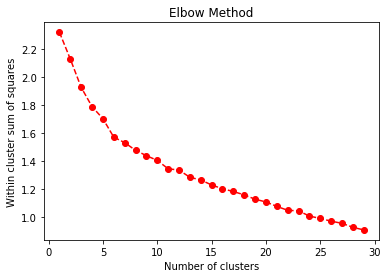

In [392]:
#Elbow methode
wcss=[]
for i in range(1,30):
    kmc= KMeans(n_clusters=i)
    kmc.fit(data)
    wcss.append(kmc.inertia_)
plt.plot(list(range(1,30)),wcss,'--ro')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares')

According to the Elbow plot, it seems like after 5 clusters there won't be a significance change in within cluster sum of squares error. So we rerun the K-Means with 5 clusters.

In [393]:
kmc= KMeans(n_clusters=5, random_state=0)
kmc.fit(data)
labels= pd.DataFrame({'Cluster Labels':kmc.labels_})
five_k= pd.concat([labels,top10],axis=1)
five_k= to_loc.merge(five_k,on='Postcode')

Finally, let's visualize the resulting clusters

In [394]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# marker colors
markers = ['#3e31ff','#ff4229','#ffff00','#2aff43','#d121dd']

# add markers
for lat, lon, poi, cluster in zip(five_k['Latitude'], five_k['Longitude'],
                                  five_k['Postcode'], five_k['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers[cluster],
        fill=True,
        fill_color=markers[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters<a class="anchor" id="5-bullet"></a>

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [395]:
n_cl= five_k[five_k['Cluster Labels']==0].shape[0]
print(f'There are {n_cl} clusters in this group.')
five_k[five_k['Cluster Labels']==0]

There are 14 clusters in this group.


,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,M3B,43.745906,-79.352188,0,Office,Building,Medical Center,Tech Startup,Doctor's Office,Conference Room,Trade School,School,Church,Japanese Restaurant
27,M3C,43.725900,-79.340923,0,Office,Building,Conference Room,Medical Center,Coworking Space,General College & University,Coffee Shop,Sporting Goods Shop,Automotive Shop,Café
29,M3J,43.767980,-79.487262,0,Office,Building,Medical Center,Automotive Shop,Furniture / Home Store,Spa,Gas Station,Bank,Salon / Barbershop,Government Building
49,M4V,43.686412,-79.400049,0,Office,Residential Building (Apartment / Condo),Doctor's Office,Building,Medical Center,Light Rail Station,Dentist's Office,Coffee Shop,Taxi,Embassy / Consulate
53,M5A,43.654260,-79.360636,0,Office,Coffee Shop,Park,Automotive Shop,Furniture / Home Store,Pub,Café,Italian Restaurant,Bakery,Rental Car Location
55,M5C,43.651494,-79.375418,0,Office,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Building,Diner,Breakfast Spot,Residential Building (Apartment / Condo)
56,M5E,43.644771,-79.373306,0,Office,Building,Coffee Shop,Road,Tech Startup,Residential Building (Apartment / Condo),Café,Pub,Hotel,Breakfast Spot
60,M5K,43.647177,-79.381576,0,Office,Coffee Shop,Café,Restaurant,Hotel,Cocktail Bar,Bakery,Italian Restaurant,Salad Place,Bar
61,M5L,43.648198,-79.379817,0,Office,Coffee Shop,Café,Restaurant,Hotel,Bakery,Deli / Bodega,Food Court,Italian Restaurant,Financial or Legal Service
69,M5W,43.646435,-79.374846,0,Office,Coffee Shop,Hotel,Café,Building,Japanese Restaurant,Pub,Restaurant,Gym,Italian Restaurant


In [396]:
n_cl= five_k[five_k['Cluster Labels']==1].shape[0]
print(f'There are {n_cl} clusters in this group.')
five_k[five_k['Cluster Labels']==1]

There are 73 clusters in this group.


,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M1E,43.763573,-79.188711,1,Electronics Store,Residential Building (Apartment / Condo),Church,Restaurant,Bus Line,Bus Stop,Thrift / Vintage Store,School,Salon / Barbershop,Building
3,M1G,43.770992,-79.216917,1,Cosmetics Shop,Pharmacy,Indian Restaurant,Coffee Shop,Building,Salon / Barbershop,South Indian Restaurant,Mobile Phone Shop,Thrift / Vintage Store,Office
4,M1H,43.773136,-79.239476,1,Medical Center,Building,Doctor's Office,Bakery,Office,Caribbean Restaurant,Automotive Shop,Residential Building (Apartment / Condo),Skating Rink,Pharmacy
5,M1J,43.744734,-79.239476,1,Residential Building (Apartment / Condo),Building,Automotive Shop,Pizza Place,Fast Food Restaurant,Convenience Store,Gas Station,Church,Salon / Barbershop,Gym / Fitness Center
6,M1K,43.727929,-79.262029,1,Dentist's Office,Church,Chinese Restaurant,Parking,Office,Discount Store,Doctor's Office,Residential Building (Apartment / Condo),Pharmacy,Pizza Place
7,M1L,43.711112,-79.284577,1,Bus Line,Park,Parking,Automotive Shop,Residential Building (Apartment / Condo),Road,Intersection,Bakery,Diner,Doctor's Office
8,M1M,43.716316,-79.239476,1,Pizza Place,Office,Dentist's Office,Church,Fast Food Restaurant,Spa,School,Salon / Barbershop,Residential Building (Apartment / Condo),Convenience Store
9,M1N,43.692657,-79.264848,1,Church,General Entertainment,Indian Restaurant,Office,Fast Food Restaurant,Park,Bar,Thai Restaurant,Bus Line,Antique Shop
11,M1R,43.750072,-79.295849,1,Middle Eastern Restaurant,Office,Grocery Store,Medical Center,Coffee Shop,Intersection,Burger Joint,Breakfast Spot,Pizza Place,Pharmacy
13,M1T,43.781638,-79.304302,1,Doctor's Office,Chinese Restaurant,Automotive Shop,Bank,Gas Station,Road,Dentist's Office,Auto Dealership,Building,Fried Chicken Joint


In [397]:
n_cl= five_k[five_k['Cluster Labels']==2].shape[0]
print(f'There is {n_cl} cluster in this group.')
five_k[five_k['Cluster Labels']==2]

There is 1 cluster in this group.


,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,M5V,43.628947,-79.39442,2,Plane,Airport Gate,Airport Service,Moving Target,Airport Terminal,Harbor / Marina,General Travel,Park,Airport Lounge,Boat or Ferry


In [398]:
n_cl= five_k[five_k['Cluster Labels']==3].shape[0]
print(f'There are {n_cl} clusters in this group.')
five_k[five_k['Cluster Labels']==3]

There are 7 clusters in this group.


,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,M2L,43.757490,-79.374714,3,Park,Residential Building (Apartment / Condo),Road,High School,Church,Pool,Synagogue,School,Buffet,Tennis Court
23,M2P,43.752758,-79.400049,3,Residential Building (Apartment / Condo),Office,Park,Church,Building,Medical Center,Rental Car Location,General Entertainment,School,Government Building
24,M2R,43.782736,-79.442259,3,Residential Building (Apartment / Condo),Bank,Medical Center,Park,Synagogue,Dentist's Office,Financial or Legal Service,Doctor's Office,Cemetery,Pizza Place
34,M4A,43.725882,-79.315572,3,Residential Building (Apartment / Condo),Office,Building,Automotive Shop,Road,Park,Dentist's Office,Government Building,Auto Dealership,Bus Stop
45,M4P,43.712751,-79.390197,3,Residential Building (Apartment / Condo),Office,Building,Medical Center,Strip Club,Breakfast Spot,Dentist's Office,Dog Run,Hotel,Gym
50,M4W,43.679563,-79.377529,3,Residential Building (Apartment / Condo),Office,Building,Road,Park,Bank,Trail,Other Great Outdoors,Salon / Barbershop,Bridge
91,M8Y,43.636258,-79.498509,3,Residential Building (Apartment / Condo),Park,Bus Line,Elementary School,Office,Convenience Store,School,Grocery Store,High School,Playground


In [399]:
n_cl= five_k[five_k['Cluster Labels']==4].shape[0]
print(f'There are {n_cl} clusters in this group.')
five_k[five_k['Cluster Labels']==4]

There are 8 clusters in this group.


,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,43.806686,-79.194353,4,Office,Automotive Shop,Factory,Doctor's Office,Fast Food Restaurant,Building,Medical Center,Dentist's Office,Salon / Barbershop,Coffee Shop
1,M1C,43.784535,-79.160497,4,Automotive Shop,Office,Medical Center,Salon / Barbershop,General Entertainment,Road,Bar,Breakfast Spot,Gas Station,Assisted Living
10,M1P,43.757410,-79.273304,4,Automotive Shop,Furniture / Home Store,Office,Building,Factory,Auto Garage,Caribbean Restaurant,Indian Restaurant,Fast Food Restaurant,Shop & Service
12,M1S,43.794200,-79.262029,4,Automotive Shop,Office,Building,Hardware Store,Doctor's Office,Post Office,Storage Facility,Factory,General Entertainment,Rental Car Location
71,M6A,43.718518,-79.464763,4,Furniture / Home Store,Clothing Store,Office,Women's Store,Design Studio,Miscellaneous Shop,Accessories Store,Automotive Shop,Bridal Shop,Building
76,M6H,43.669005,-79.442259,4,Automotive Shop,Park,Church,Office,Furniture / Home Store,Portuguese Restaurant,Music Venue,Supermarket,Bakery,Factory
92,M8Z,43.628841,-79.520999,4,Office,Coworking Space,Automotive Shop,Building,Miscellaneous Shop,Fast Food Restaurant,Gym / Fitness Center,Social Club,Hardware Store,Church
96,M9L,43.756303,-79.565963,4,Automotive Shop,Gas Station,Bank,Church,Furniture / Home Store,Office,Building,Storage Facility,Electronics Store,Italian Restaurant


## 6. Conclusion<a class="anchor" id="6-bullet"></a>

Based on the defining categories, we can then assign a name to each cluster. Our clustering seems to make a lot of sense and here are the results after looking at the categories.

| Cluster Label   |      Cluster Name      | Highlights |
|-----------------|------------------------|------------|
| 0               | Business District      | Offices, Conference rooms and Tech Startups |
| 1               | Residential Area       | Residential Buildings |
| 2               | Airport                | Airport |
| 3               | Rural Area             | Parks and Green Areas |
| 4               | Downtown               | Shops, Banks, .. |

_______

This notebook was created by [Siavash Saki](https://www.linkedin.com/in/siavash-saki/). Don't hesitate to contact me if you have any question!\
Inpired by the course **IBM Applied Data Science Capstone** tought by by Alex Aklson and Polong Lin.